## LSTM Model

In [1]:
import glob
import pandas as pd
import numpy as np
from numpy import concatenate
from numpy import sqrt
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    
    return df_data

In [3]:
fpath = "..\\data\\all_raw_files"
model_data_file = "model_data.csv"
model_data = read_data(f'{fpath}\{model_data_file}')

In [4]:
model_data

,year,month,date,temp_mean,temp_min,temp_max,temp_avg_daily_min,temp_avg_daily_max,degree_days,demand_mean,demand_max,demand_avg_daily_max,total_consumption,pv_capacity,population,gsp
0,2010,1,2010-01-01,20.868008,1.6,41.1,16.380645,25.858065,144.511358,8941.450389,13765.04,10613.530000,6554083.135,28278.392,7110454,44504.250000
1,2010,2,2010-02-01,20.218907,3.2,35.4,16.146429,24.682143,124.982743,8855.467677,13377.27,10380.667857,5831325.465,32153.986,7119405,44504.250000
2,2010,3,2010-03-01,19.828286,6.3,34.7,15.496774,24.725806,106.809763,8698.725127,11991.47,10132.978710,6319623.805,38195.588,7128356,44504.250000
3,2010,4,2010-04-01,17.593856,6.5,29.9,12.780000,23.063333,68.136038,8452.863411,11436.13,9804.072333,5984627.295,45142.723,7133668,44504.250000
4,2010,5,2010-05-01,15.323485,3.1,28.4,11.187097,19.596774,123.937772,8897.770510,12386.49,10558.023548,6459781.390,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,8,2021-08-01,21.104167,16.9,30.7,17.766667,24.966667,9.312500,7368.353056,9043.62,8410.176667,530521.420,3954209.744,8091356,57391.083333
140,2021,9,2021-09-01,20.999306,14.2,27.5,15.433333,25.300000,8.997917,7229.393819,9206.19,8469.680000,520516.355,4033918.477,8088503,57391.083333
141,2021,10,2021-10-01,21.084722,14.8,26.9,16.300000,25.466667,9.254167,7209.823194,8841.21,8575.093333,519107.270,4112353.036,8092743,57391.083333
142,2021,11,2021-11-01,22.118056,15.7,27.3,16.466667,26.566667,12.354167,7649.492569,9573.70,9336.970000,550763.465,4192992.282,8096983,57391.083333


## Decision on data to test, Temp_mean , pv_capacity, population ~ demand_mean_max

In [5]:
model_data_new = model_data[["degree_days", "pv_capacity", "population", "demand_avg_daily_max"]]
#Scale the model array
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(model_data_new)
model_data_new = scaler.transform(model_data_new)
# Split training and testing data, testing data is last 24 months
model_data_new.shape
nn_train_x, nn_test_x, nn_train_y, nn_test_y  = train_test_split(model_data_new[ : , 0 : -1], model_data_new[: , -1] , test_size=0.4)

# reshape input to be 3D [samples, timesteps, features]

print(nn_train_x.shape, nn_train_y.shape, nn_test_x.shape, nn_test_y.shape)

(86, 3) (86,) (58, 3) (58,)


In [6]:
nn_train_x

array([[ 0.10442177, -0.59872712, -0.01734217],
       [ 0.85983324, -0.98152703, -0.93242853],
       [ 0.56887249, -0.79478086, -0.58190679],
       [-0.23768852, -0.75036483, -0.44180752],
       [-0.35269165, -0.99208838, -0.95364371],
       [ 0.03931973, -0.7183768 , -0.34409269],
       [ 0.17931973, -0.56356046,  0.06808767],
       [-0.20559499,  0.41985557,  0.97384846],
       [ 0.06501134, -0.84515579, -0.74225074],
       [ 0.37006803,  0.27200218,  0.99814886],
       [-0.42143774, -0.8795281 , -0.80254546],
       [-0.33469388, -0.68744088, -0.23274894],
       [ 0.62689342, -0.46567909,  0.36822536],
       [ 0.1514059 ,  0.50430685,  0.96771794],
       [ 0.0385034 ,  0.55383589,  0.96465268],
       [ 0.06824685, -0.99534751, -0.9642513 ],
       [ 0.44759637, -0.5701877 ,  0.04867969],
       [ 0.17961415, -0.95802332, -0.89561748],
       [ 0.19120181, -0.51507247,  0.22594746],
       [-0.2053288 ,  0.2131224 ,  1.        ],
       [ 0.9253288 , -0.24062961,  0.705

Epoch 1/50
3/3 - 1s - loss: 0.2300 - val_loss: 0.1277 - 1s/epoch - 367ms/step
Epoch 2/50
3/3 - 0s - loss: 0.1305 - val_loss: 0.0829 - 53ms/epoch - 18ms/step
Epoch 3/50
3/3 - 0s - loss: 0.0947 - val_loss: 0.0713 - 43ms/epoch - 14ms/step
Epoch 4/50
3/3 - 0s - loss: 0.0783 - val_loss: 0.0522 - 40ms/epoch - 13ms/step
Epoch 5/50
3/3 - 0s - loss: 0.0671 - val_loss: 0.0409 - 41ms/epoch - 14ms/step
Epoch 6/50
3/3 - 0s - loss: 0.0666 - val_loss: 0.0401 - 39ms/epoch - 13ms/step
Epoch 7/50
3/3 - 0s - loss: 0.0664 - val_loss: 0.0370 - 44ms/epoch - 15ms/step
Epoch 8/50
3/3 - 0s - loss: 0.0600 - val_loss: 0.0352 - 45ms/epoch - 15ms/step
Epoch 9/50
3/3 - 0s - loss: 0.0547 - val_loss: 0.0343 - 41ms/epoch - 14ms/step
Epoch 10/50
3/3 - 0s - loss: 0.0516 - val_loss: 0.0327 - 37ms/epoch - 12ms/step
Epoch 11/50
3/3 - 0s - loss: 0.0503 - val_loss: 0.0320 - 46ms/epoch - 15ms/step
Epoch 12/50
3/3 - 0s - loss: 0.0496 - val_loss: 0.0320 - 39ms/epoch - 13ms/step
Epoch 13/50
3/3 - 0s - loss: 0.0480 - val_loss: 0.

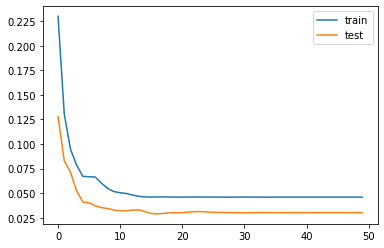

In [10]:
# Run model
# design network
hidden_nodes=40
model = Sequential()
model.add(Dense(hidden_nodes))
model.add(Dense(hidden_nodes))
model.add(Dense(hidden_nodes))
model.add(Dense(hidden_nodes))
model.add(Dense(hidden_nodes))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(nn_train_x, nn_train_y, epochs=50, batch_size=32, validation_data=(nn_test_x, nn_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

2/2 [==============================] - 0s 0s/step


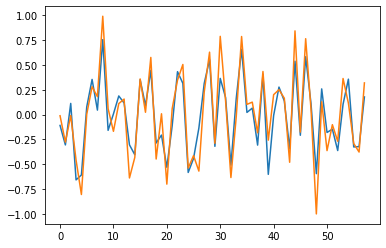

In [11]:
# make a prediction
yhat = model.predict(nn_test_x)
yhat
plt.plot(yhat)
plt.plot(nn_test_y)

In [12]:
# make a prediction
# invert scaling for forecast
inv_yhat = concatenate((nn_test_x, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,3]
# invert scaling for actual
nn_test_y = nn_test_y.reshape((len(nn_test_y), 1))
inv_y = concatenate((nn_test_x, nn_test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,3]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test MAPE: %.3f' % mape)

Test RMSE: 275.324
Test MAPE: 0.023
